# Análise Exploratória de Dados (1)

## Objetivos possíveis:

* **Prever atrasos de voos**
* Analisar fatores relacionados a voos que causam atraso
* Analisar fatores relacionados a voos atrasados atribuíveis à companhia aérea.
* Classificar aeroportos
* Classificar companhias aéreas

## Leitura inicial

Definir SparkContext e SQLContext

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

Lendo o arquivo de trabalho

In [3]:
bd = sqlContext.read.format("com.databricks.spark.csv"
).option("header", "true"
).load("file:/home/cloudera/Time.csv", inferSchema=True
)

## Pré-processo inicial

Filtrar variáveis ​​de interesse e principais aeroportos

In [4]:
bd=bd.select('Year','Month','DAY_OF_MONTH','DAY_OF_WEEK','CRS_DEP_TIME','OP_UNIQUE_CARRIER',
             'TAIL_NUM', 'ARR_DELAY','DEP_DELAY','ORIGIN','DEST','DISTANCE','CANCELLED', 'DIVERTED',
             'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY')

In [5]:
sqlContext.registerDataFrameAsTable(bd, "bd")
bd2 = sqlContext.sql("select * from bd \
            where ORIGIN in ('ATL','ORD','DEN','LAX','DFW','SFO','PHX','LAS') \
            and DEST in ('ATL','ORD','DEN','LAX','DFW','SFO','PHX','LAS')")
sqlContext.registerDataFrameAsTable(bd2, "bd2")

# Exploração de Variáveis
Dados (variáveis) são características observáveis ​​de indivíduos em uma população. Essas variáveis ​​podem ser:

* __QUALITATIVA__: rótulos (numéricos ou não) que representam o grupo ou categoria a que um indivíduo pertence. Você pode diferenciar entre nominal e ordinal.

* __QUANTITATIVA__: valores numéricos para os quais faz sentido fazer aritmética. Pode-se diferenciar entre valores inteiros (discretos) e valores medidos em uma determinada escala (contínuo).



## Exploração de Variáveis ​​Qualitativas
* Número de casos disponíveis
* Número de categorias
* Frequências Relativas
* Frequências absolutas
* Frequencia. relativo cumulativo
* Frequencia. absoluto cumulativo

In [6]:
bd2.count()

30965

In [7]:
bd2.select("DEST").distinct().count()

8

In [8]:
bd2.groupBy("DEST").count().show()

+----+-----+
|DEST|count|
+----+-----+
| ORD| 3829|
| LAS| 3726|
| LAX| 5342|
| ATL| 3094|
| DEN| 3967|
| PHX| 3302|
| DFW| 3275|
| SFO| 4430|
+----+-----+



In [9]:
sqlContext.sql("select DEST, count(*) as n , round(  100*count(*)/30965  ,2) as p \
                from bd2 \
                group by DEST  ").show()

+----+----+-----+
|DEST|   n|    p|
+----+----+-----+
| ORD|3829|12.37|
| LAS|3726|12.03|
| LAX|5342|17.25|
| ATL|3094| 9.99|
| DEN|3967|12.81|
| PHX|3302|10.66|
| DFW|3275|10.58|
| SFO|4430|14.31|
+----+----+-----+



In [11]:
sqlContext.sql("select t1.DEST , t1.n , 100*t1.n/t2.t as p\
               from (select DEST, count(*) as n from bd2 group by DEST ) as t1 , \
               (select count(*) as t from bd2) as t2").show()

+----+----+------------------+
|DEST|   n|                 p|
+----+----+------------------+
| ORD|3829|12.365574035201034|
| LAS|3726|12.032940416599386|
| LAX|5342|17.251735830776685|
| ATL|3094| 9.991926368480543|
| DEN|3967|12.811238495075084|
| PHX|3302|10.663652510899402|
| DFW|3275|10.576457290489262|
| SFO|4430|14.306475052478605|
+----+----+------------------+



## Exploração de Variáveis ​​Quantitativas

* Número de casos disponíveis
* Medidas de localização
   * Média: centro de massa
   * Mediana: ponto médio (50% da amostra)
* Medidas de dispersão
   * Variação / desvio padrão
   * Quartis Q3 e Q1 (25% e 75% da amostra)
   * Faixa Interquartil: IQR = Q3 - Q1
   * Faixa = máx. - mín.
* Valores extremos
   * Máximo e mínimo; cabeçalho e rodapé
   * Percentis (1%, 99%)
   * Porcentagem de casos 'acima/abaixo'.

In [12]:
bd2.describe("ARR_DELAY").show()

+-------+------------------+
|summary|         ARR_DELAY|
+-------+------------------+
|  count|             30466|
|   mean|13.300695857677411|
| stddev|  53.5094673816375|
|    min|             -53.0|
|    max|            2028.0|
+-------+------------------+



In [13]:
bd2.select('ARR_DELAY').groupBy().max().collect

<bound method DataFrame.collect of DataFrame[max(ARR_DELAY): double]>

In [14]:
sqlContext.sql("select min(ARR_DELAY) as Min, \
                max(ARR_DELAY) as Max from bd2" ).show()

+-----+------+
|  Min|   Max|
+-----+------+
|-53.0|2028.0|
+-----+------+



In [15]:
bd2.select('ARR_DELAY').orderBy('ARR_DELAY',ascending=False).show(10)

+---------+
|ARR_DELAY|
+---------+
|   2028.0|
|   1505.0|
|   1006.0|
|    996.0|
|    951.0|
|    920.0|
|    920.0|
|    873.0|
|    872.0|
|    868.0|
+---------+
only showing top 10 rows



In [16]:
n=bd2.select('ARR_DELAY').count()
P95=int(n*0.95)
bd2.select('ARR_DELAY').sort('ARR_DELAY').collect()[P95]

Row(ARR_DELAY=103.0)

## Representação gráfica de variáveis ​​qualitativas

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
g1=sqlContext.sql("select DEST, count(*) as n from bd2 group by Dest")
pdf1=g1.toPandas()
pdf1

,DEST,n
0,ORD,3829
1,LAS,3726
2,LAX,5342
3,ATL,3094
4,DEN,3967
5,PHX,3302
6,DFW,3275
7,SFO,4430


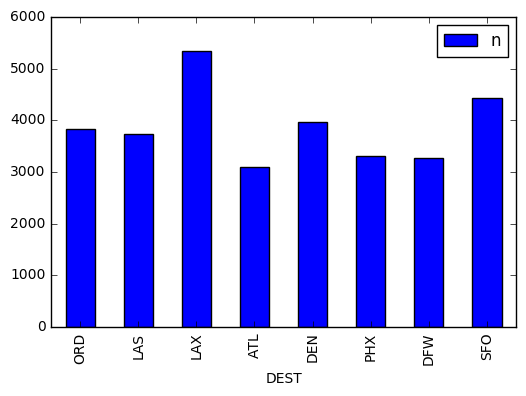

In [20]:
pdf1.plot(kind='bar',x='DEST',y='n')

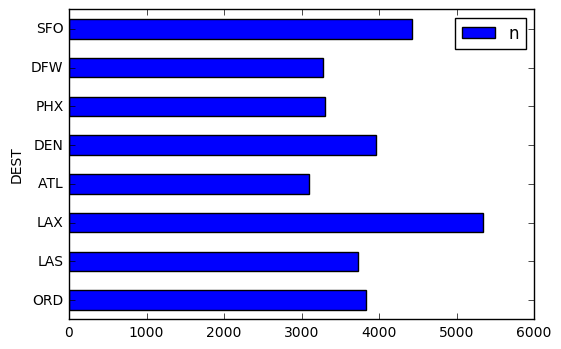

In [21]:
pdf1.plot(kind='barh',x='DEST',y='n')

## Representação gráfica de variáveis ​​quantitativas

Apenas os dados de uma amostra são representados.

In [22]:
#pdf2 = bd2.select('ArrDelay').toPandas()
pdf2 = bd2.sample(False, 0.1, 0).select('ARR_DELAY').toPandas()

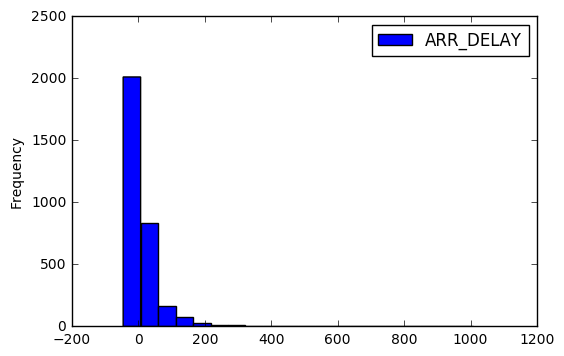

In [23]:
pdf2.plot.hist(bins=20)

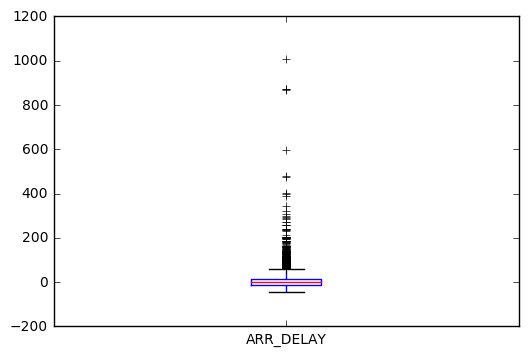

In [24]:
pdf2.plot.box()